# Predicción de presupuesto de campañas en Meta Ads mediante Regresión Lineal

## Análisis Exploratorio

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [3]:
df=pd.read_excel (r'Test Dataset.xlsx')

In [4]:
df.shape

(90, 15)

In [5]:
df.isna().sum()

Año                   0
Mes                   0
Ads                   0
Reach                 0
Frequency             0
Impressions           0
Clicks                0
CPC USD               0
Investment USD        0
Objective             0
Leads                 0
Unique Link Clicks    0
Landing Page Views    0
CPM USD               0
Outbound Clicks       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Año                 90 non-null     int64  
 1   Mes                 90 non-null     int64  
 2   Ads                 90 non-null     object 
 3   Reach               90 non-null     int64  
 4   Frequency           90 non-null     float64
 5   Impressions         90 non-null     int64  
 6   Clicks              90 non-null     int64  
 7   CPC USD             90 non-null     float64
 8   Investment USD      90 non-null     float64
 9   Objective           90 non-null     object 
 10  Leads               90 non-null     int64  
 11  Unique Link Clicks  90 non-null     int64  
 12  Landing Page Views  90 non-null     int64  
 13  CPM USD             90 non-null     float64
 14  Outbound Clicks     90 non-null     int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 10.7+ KB


### Inversión acumulada por objetivo

In [7]:
inv_obj=df.groupby('Objective')['Investment USD'].sum().reset_index()
inv_obj

,Objective,Investment USD
0,CONVERSIONS,13560.28
1,LEAD_GENERATION,16537.53
2,LINK_CLICKS,1760.06
3,REACH,4040.84


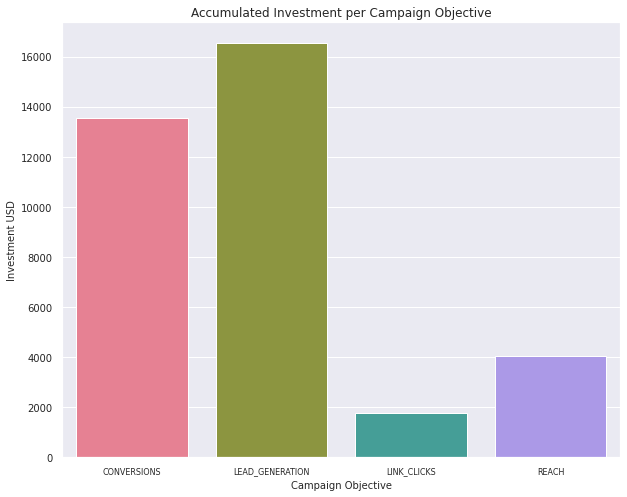

In [8]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Objective', y='Investment USD', data=inv_obj, ax=ax, palette='husl')
plt.xticks(rotation = 0, fontsize=8)
plt.yticks(rotation = 0, fontsize=10)
plt.xlabel('Campaign Objective', fontsize=10)
plt.ylabel('Investment USD', fontsize=10)
plt.title('Accumulated Investment per Campaign Objective', fontsize=12)
plt.show()

En términos generales las campañas de conversión o leads suelen ser las más costosas, ya que en ambos casos se trata de acciones de alto valor o "esfuerzo" por parte del usuario (compra, suscripción, etc.) en comparación a acciones de menos "compromiso" como la visualización de un anuncio o clicks sobre él.

En este caso, se condice con lo mencionado, dado que se observa una inversión mayor en campañas de conversión y generación de leads en el periodo analizado.

### Inversión acumulada mensual

In [9]:
inv_month=df.groupby(['Año', 'Mes'])['Investment USD'].sum().reset_index()
inv_month['Año-Mes']=inv_month["Año"].astype(str) + "-" + inv_month["Mes"].astype(str)
inv_month=inv_month.drop(['Año', 'Mes'], axis=1)
inv_month=inv_month.reindex(columns=['Año-Mes','Investment USD'])
inv_month

,Año-Mes,Investment USD
0,2021-9,2935.48
1,2021-10,3419.28
2,2021-11,3477.06
3,2021-12,9627.41
4,2022-1,16439.48


In [10]:
series=inv_month['Investment USD'].squeeze()

In [11]:
series.pct_change()*100

0           NaN
1     16.481121
2      1.689829
3    176.883632
4     70.757036
Name: Investment USD, dtype: float64

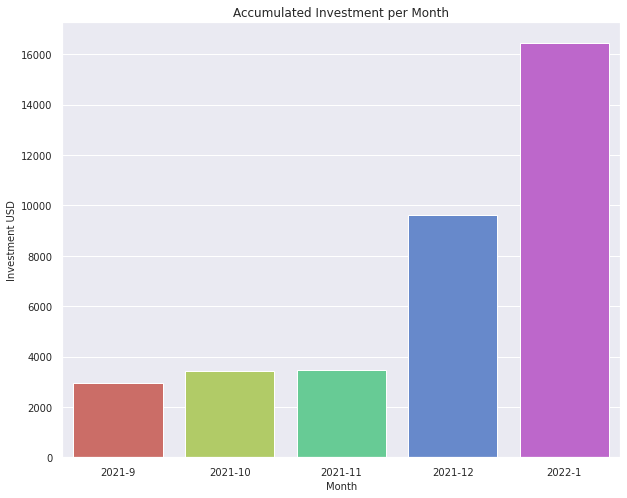

In [12]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Año-Mes', y='Investment USD', data=inv_month, ax=ax, palette='hls')
plt.xticks(rotation = 0, fontsize=10)
plt.yticks(rotation = 0, fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Investment USD', fontsize=10)
plt.title('Accumulated Investment per Month', fontsize=12)
plt.show()

De acuerdo a lo observado en el gráfico, la inversión mensual en campañas se ve incrementada significativamente hacia los dos últimos meses analizados. No obstante, a lo largo del periodo se observa un incremento porcentual de diferente magnitud entre cada mes.

### Análisis de correlación entre variables

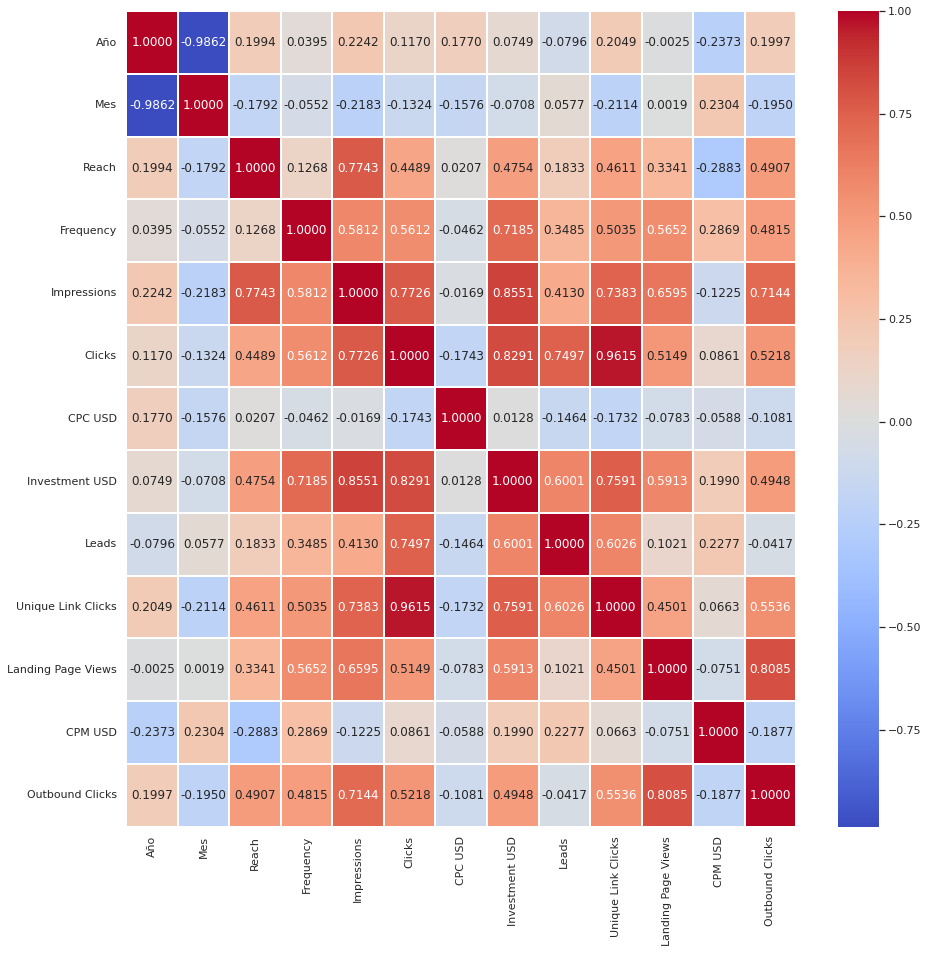

In [13]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(method='pearson'),linewidths=.1,cmap='coolwarm', annot=True, fmt='.4f')
plt.yticks(rotation=0);

El análisis de correlación realizado corresponde al de Pearson, por ser el más adecuado para variables cuantitativas. Podemos observar en el mapa de calor que el conjunto de datos posee una gran variabilidad y pocas variables altamente correlacionadas. La mayor parte de esta alta correlación se encuentra entre la variable inversión y cantidad de clicks, impresiones, alcance, vistas de landing, etc. 

Variables como clicks y clicks únicos, pueden ser redundantes al momento de entrenar los modelos, por lo tanto se puede decidir eliminar una de ellas.

### Histogramas de frecuencias

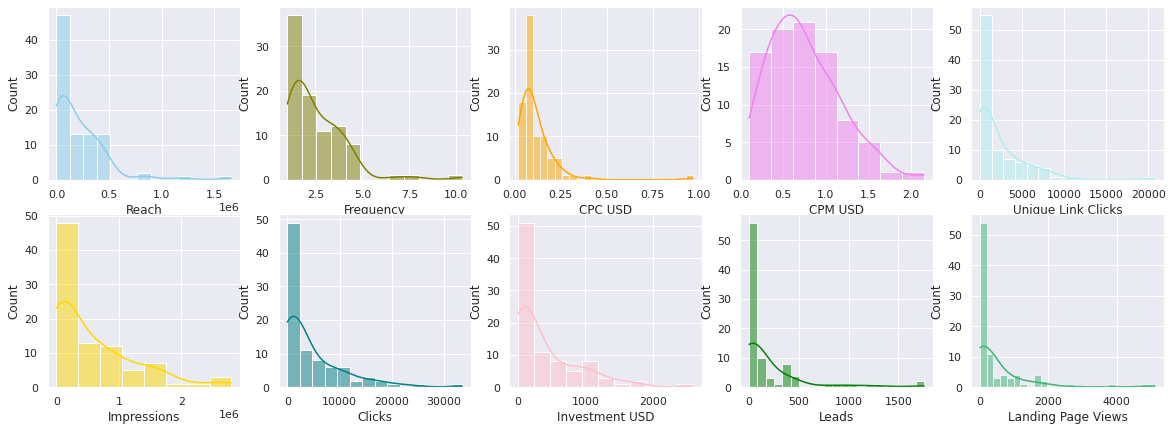

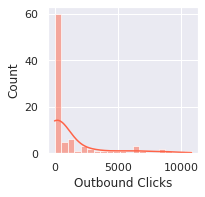

In [14]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 5, figsize=(20, 7))
sns.histplot(data=df, x="Reach", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="Frequency", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="Impressions", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="Clicks", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df, x="CPC USD", kde=True, color="orange", ax=axs[0, 2])
sns.histplot(data=df, x="Investment USD", kde=True, color="pink", ax=axs[1, 2])
sns.histplot(data=df, x="CPM USD", kde=True, color="violet", ax=axs[0, 3])
sns.histplot(data=df, x="Leads", kde=True, color="green", ax=axs[1, 3])
sns.histplot(data=df, x="Unique Link Clicks", kde=True, color="paleturquoise", ax=axs[0, 4])
sns.histplot(data=df, x="Landing Page Views", kde=True, color="mediumseagreen", ax=axs[1, 4])

fig, ax = plt.subplots(figsize=(2.7, 2.7))
sns.histplot(data=df, x="Outbound Clicks", kde=True, color="tomato")

plt.show()

Se observa en la mayoría de los histogramas una asimetría positiva en las distribucion de frecuencias. Asimismo, en muchas variables se presentan valores atípicos que influencian la distribución. 

Es de relevancia considerar un rescaleo de datos previo al entrenamiento de modelos de regresión para unificar la escala de los datos y aproximar a distribuciones normales para las variables.

### Análisis de Frequency vs. Unique Link Clicks

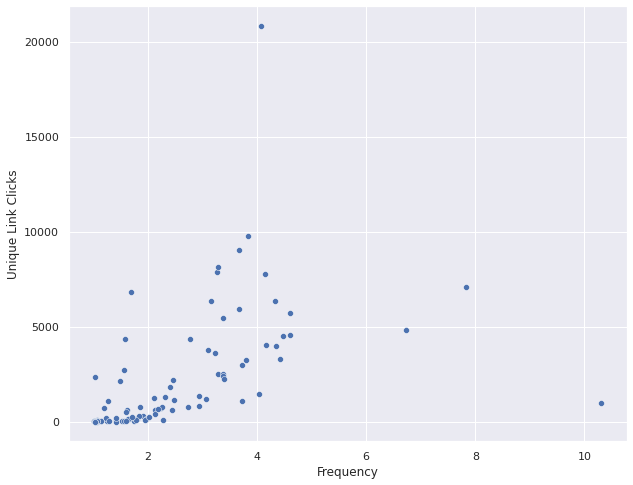

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='Frequency', y='Unique Link Clicks')
plt.show()

/home/gr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


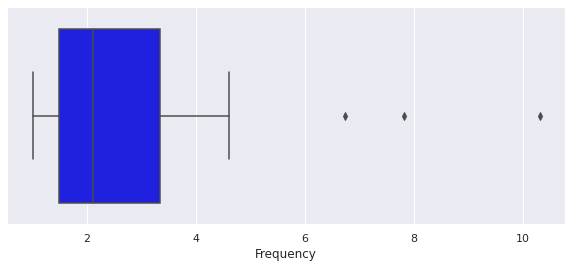

In [16]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df['Frequency'], color='blue')
plt.show()

/home/gr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


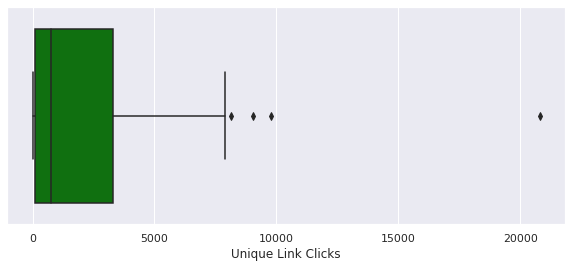

In [17]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df['Unique Link Clicks'], color='green')
plt.show()

In [18]:
q75,q25=df['Frequency'].quantile([0.75,0.25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)

In [19]:
df=df[(df['Frequency']>min)&(df['Frequency']<max)]

In [20]:
q75,q25=df['Unique Link Clicks'].quantile([0.75,0.25])
iqr=q75-q25
min=q25-(iqr*1.5)
max=q75+(iqr*1.5)

In [21]:
df=df[(df['Unique Link Clicks']>min)&(df['Unique Link Clicks']<max)]

/home/gr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


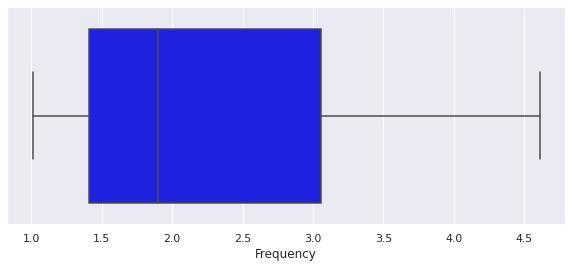

In [22]:
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df['Frequency'], color='blue')
plt.show()

/home/gr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


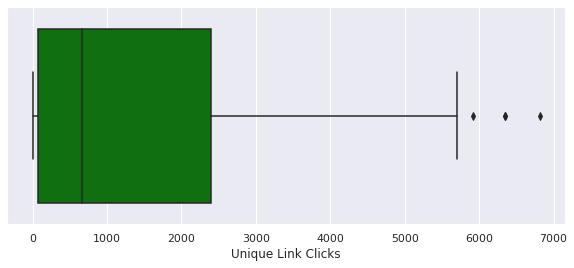

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df['Unique Link Clicks'], color='green')

plt.show()

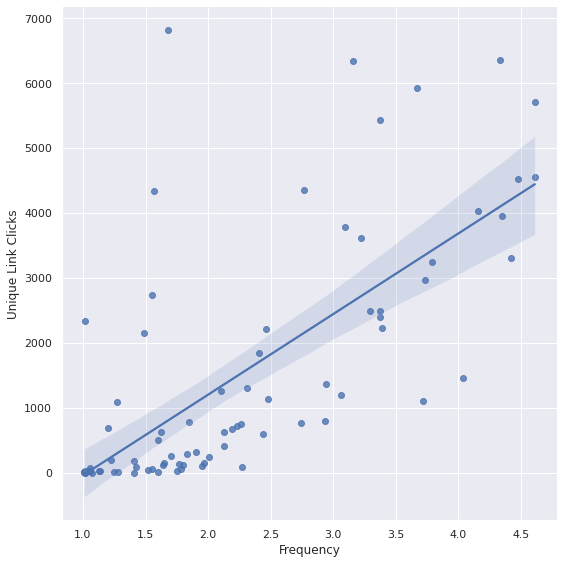

In [24]:
sns.lmplot(x='Frequency', y='Unique Link Clicks', data=df, height=8)
plt.show()

En el primer gráfico de dispersión se observaron valores atípicos de ambas variables, por lo que se eliminaron a través del rango intercuartílico para poder encontrar la recta que mejor ajuste lineal.

En tanto, se observa una correlación lineal significativa entre las variables Frequency vs. Unique Link Clicks.

## Análisis predictivo

**Feature Engineering**

In [25]:
df_obj = pd.get_dummies(df['Objective'])
df_obj.head()

,CONVERSIONS,LEAD_GENERATION,LINK_CLICKS,REACH
1,1,0,0,0
2,1,0,0,0
4,0,1,0,0
7,1,0,0,0
8,0,1,0,0


In [26]:
df=pd.concat([df, df_obj], axis=1).drop(['Objective'], axis=1)

### Modelos

In [27]:
y=df['Investment USD']

In [28]:
X=df.drop(['Investment USD', 'Unique Link Clicks', 'Ads', 'Año', 'Mes'], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

**1) Linear Regression**

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg= LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
y_pred = lin_reg.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,600.493301
1,982.000105
2,268.252535
3,1080.472168
4,777.003251
5,246.224167
6,95.015120
7,367.851896
8,334.093674
9,-48.551568


In [33]:
MAE_lin_reg= metrics.mean_absolute_error(y_test, y_pred)
MSE_lin_reg= metrics.mean_squared_error(y_test, y_pred)
RMSE_lin_reg= np.sqrt(MSE_lin_reg)
R2_lin_reg= r2_score(y_test, lin_reg.predict(X_test_scaled))
pd.DataFrame([MAE_lin_reg, MSE_lin_reg, RMSE_lin_reg, R2_lin_reg], index=['MAE_lin_reg', 'MSE_lin_reg', 'RMSE_lin_reg', 'R2_lin_reg'], columns=['Metrics'])

,Metrics
MAE_lin_reg,96.400725
MSE_lin_reg,15110.137033
RMSE_lin_reg,122.923297
R2_lin_reg,0.898369


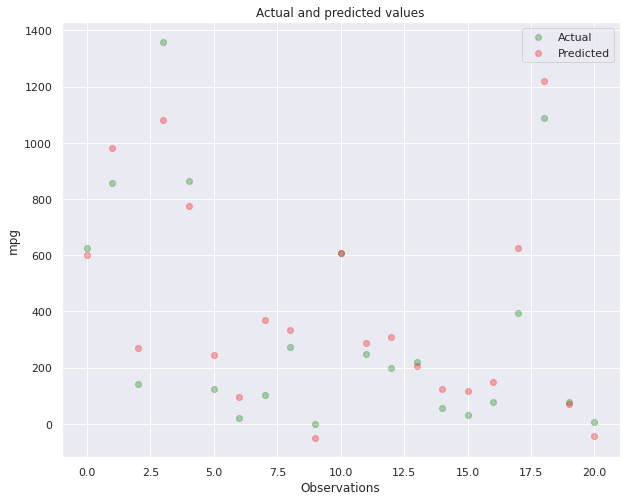

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Se puede observar a través del gráfico, que las observaciones predichas por el modelo, en cuanto al monto de inversión fueron cercanas a las observaciones reales de los datos de test.

De acuerdo a los valores de métricas arrojadas, este modelo tiene el menor valor de RMSE y un R2 alto, lo que indica predicciones con buen nivel de precisión.

### 2) Decision Tree Regressor

In [35]:
tree_reg= DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [36]:
y_pred_tree = tree_reg.predict(X_test_scaled)
y_pred_tree = pd.DataFrame(y_pred_tree)
y_pred_tree

,0
0,824.585000
1,1080.278333
2,37.372581
3,824.585000
4,400.750000
5,196.907273
6,37.372581
7,824.585000
8,400.750000
9,37.372581


In [37]:
MAE_tree_reg= metrics.mean_absolute_error(y_test, y_pred_tree)
MSE_tree_reg = metrics.mean_squared_error(y_test, y_pred_tree)
RMSE_tree_reg =np.sqrt(MSE_tree_reg)
R2_tree_reg= r2_score(y_test, tree_reg.predict(X_test_scaled))
pd.DataFrame([MAE_tree_reg, MSE_tree_reg, RMSE_tree_reg, R2_tree_reg], index=['MAE_tree_reg', 'MSE_tree_reg', 'RMSE_tree_reg', 'R2_tree_reg'], columns=['Metrics'])

,Metrics
MAE_tree_reg,184.090598
MSE_tree_reg,74048.262435
RMSE_tree_reg,272.118104
R2_tree_reg,0.501952


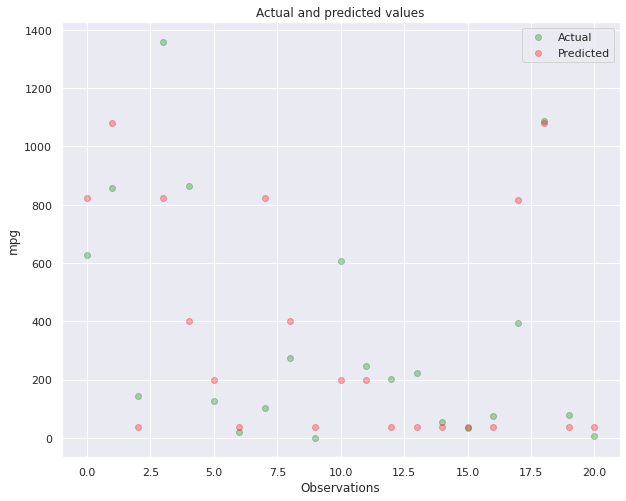

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred_tree.size), y=y_pred_tree, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Se puede observar a través del gráfico, que las observaciones predichas por el modelo, en cuanto al monto de inversión tuvieron mayor error respecto al modelo Linear Regression.

De acuerdo a los valores de métricas arrojadas, este modelo tiene un valor RMSE mayor al modelo anterior y un R2 bajo, lo que indica predicciones con menos precisión.

### 3) SVM Regressor

In [39]:
svm_reg= svm.SVR()
svm_reg.fit(X_train_scaled, y_train)

SVR()

In [40]:
y_pred_svm = svm_reg.predict(X_test_scaled)
y_pred_svm = pd.DataFrame(y_pred_svm)
y_pred_svm

,0
0,132.304760
1,134.130231
2,122.546424
3,132.291189
4,132.523398
5,126.540271
6,118.169144
7,120.005082
8,125.994932
9,118.815246


In [41]:
MAE_svm_reg= metrics.mean_absolute_error(y_test, y_pred_svm)
MSE_svm_reg = metrics.mean_squared_error(y_test, y_pred_svm)
RMSE_svm_reg =np.sqrt(MSE_svm_reg)
R2_svm_reg= r2_score(y_test, svm_reg.predict(X_test_scaled))
pd.DataFrame([MAE_svm_reg, MSE_svm_reg, RMSE_svm_reg, R2_svm_reg], index=['MAE_svm_reg', 'MSE_svm_reg', 'RMSE_svm_reg', 'R2_svm_reg'], columns=['Metrics'])

,Metrics
MAE_svm_reg,281.545859
MSE_svm_reg,196254.377541
RMSE_svm_reg,443.006069
R2_svm_reg,-0.320005


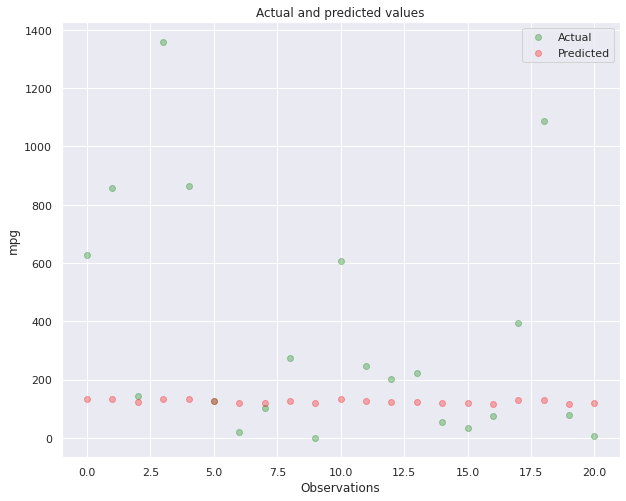

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred_svm.size), y=y_pred_svm, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Se puede observar a través del gráfico, que las observaciones predichas por el modelo, en cuanto al monto de inversión, tuvieron mayores errores respecto a los modelos 1 y 2.

De acuerdo a los valores de métricas arrojadas, este modelo tiene un valor RMSE mayor a modelos anteriores y un R2 bajo, teniendo el peor desempeño.

### 4) XGB Regressor

In [43]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
y_pred_xgb = xgb_reg.predict(X_test_scaled)
y_pred_xgb = pd.DataFrame(y_pred_xgb)
y_pred_xgb

,0
0,620.409607
1,1004.399231
2,136.315506
3,1023.960083
4,807.840027
5,148.077469
6,17.978672
7,350.803711
8,335.913025
9,0.726801


In [45]:
MAE_xgb_reg= metrics.mean_absolute_error(y_test, y_pred_xgb)
MSE_xgb_reg = metrics.mean_squared_error(y_test, y_pred_xgb)
RMSE_xgb_reg =np.sqrt(MSE_xgb_reg)
R2_xgb_reg= r2_score(y_test, xgb_reg.predict(X_test_scaled))
pd.DataFrame([MAE_xgb_reg, MSE_xgb_reg, RMSE_xgb_reg, R2_xgb_reg], index=['MAE_xgb_reg', 'MSE_xgb_reg', 'RMSE_xgb_reg', 'R2_xgb_reg'], columns=['Metrics'])

,Metrics
MAE_xgb_reg,83.544618
MSE_xgb_reg,16978.577332
RMSE_xgb_reg,130.301870
R2_xgb_reg,0.885802


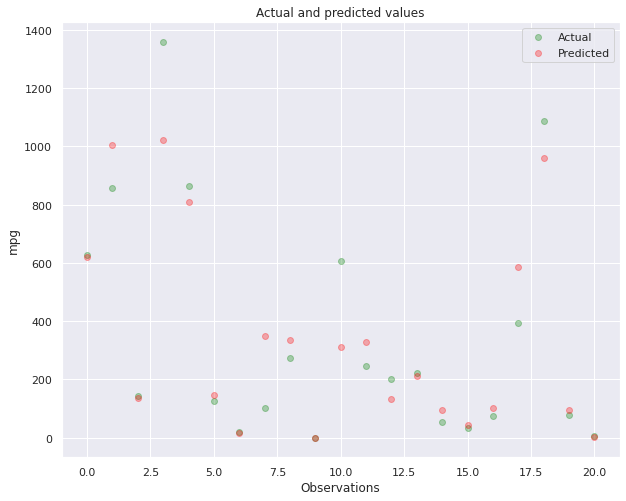

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred_xgb.size), y=y_pred_xgb, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Se puede observar a través del gráfico, que las observaciones predichas por el modelo, en cuanto al monto de inversión, tuvieron errores similares al primer modelo aplicado.

De acuerdo a los valores de métricas arrojadas, este modelo tiene un valor RMSE bajo y un R2 alto, generando predicciones con buen nivel de precisión.